In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
file = '../data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.describe()

,z,hz,err
count,31.000000,31.000000,31.000000
mean,0.661219,105.922581,21.303226
std,0.520398,38.413424,14.587768
min,0.070000,68.600000,4.000000
25%,0.275000,78.950000,12.000000
50%,0.470000,90.000000,17.000000
75%,0.890000,121.000000,27.900000
max,1.965000,202.000000,62.000000


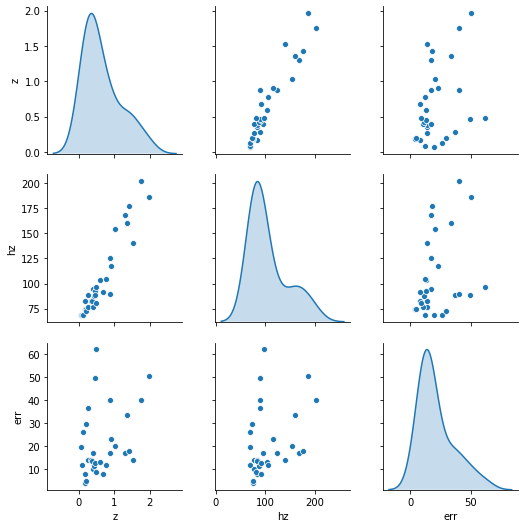

In [4]:
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistHD.png")

In [5]:
# a = np.array([25,  3,  9,  7, 19,  2, 17, 16,  6, 28, 12, 20, 21, 26, 27, 11,  1,
#        10, 30, 13, 29,  0,  8, 18, 24,  5, 23,  4, 22, 15, 14])
# randomize = np.random.permutation(len(data.values))
shuffle = [x for x in range(len(data.values)) if x%2 ==0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]
# shuffle

In [6]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


Read the data for cosmic chronometers

In [7]:

# odds = [x for x in range(len(data)) if x%2 ==0]
# even = [x for x in range(len(data)) if x%2 ==1]
# new_order = np.array(even+odds)
# new_order = np.array([x for x in range(len(data)-1, 0, -1)])
# data = data.values[new_order]
# data = data.values


In [8]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [9]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [10]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [11]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
#                                    min_delta=0.0001,
#                                    patience=20.0,
#                                    restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()


In [12]:
def model(input_z):
    efirst = Dense(150, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
#     ehidden = Dense(150, activation='relu')(efirst)
    ehidden2 = Dense(150, activation='relu')(ehidden)
    ehidden2 = Dense(150, activation='relu')(ehidden2)
    elast = Dense(2, activation='linear')(ehidden2)


    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 150)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_2 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 302       
Total params: 38,452
Trainable params: 38,452
Non-trainable params: 0
__________________________________________________

In [13]:
# batch_size = 4
batch_size = 1
epochs = 150
input_z = Input(shape = (1,))

In [14]:
# autoencoder = Model(input_z, autoencoder(input_z))
# autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
# autoencoder.summary()

In [15]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/150
24/24 [==============================] - 0s 4ms/step - loss: 5322.8237 - val_loss: 10830.6270
Epoch 2/150
24/24 [==============================] - 0s 1ms/step - loss: 4683.1450 - val_loss: 9121.0225
Epoch 3/150
24/24 [==============================] - 0s 1ms/step - loss: 2374.3093 - val_loss: 3892.2378
Epoch 4/150
24/24 [==============================] - 0s 1ms/step - loss: 792.7236 - val_loss: 538.0283
Epoch 5/150
24/24 [==============================] - 0s 1ms/step - loss: 401.7968 - val_loss: 602.9355
Epoch 6/150
24/24 [==============================] - 0s 1ms/step - loss: 305.0727 - val_loss: 527.8684
Epoch 7/150
24/24 [==============================] - 0s 1ms/step - loss: 264.2454 - val_loss: 585.6576
Epoch 8/150
24/24 [==============================] - 0s 1ms/step - loss: 213.7286 - val_loss: 484.7506
Epoch 9/150
24/24 [==============================] - 0s 1ms/step - loss: 194.5858 - val_loss: 370.9583
Epoch 10/150
24/24 [==============================] - 0s 1ms/step 

Epoch 80/150
24/24 [==============================] - 0s 1ms/step - loss: 141.9693 - val_loss: 387.3817
Epoch 81/150
24/24 [==============================] - 0s 1ms/step - loss: 181.1785 - val_loss: 597.3333
Epoch 82/150
24/24 [==============================] - 0s 1ms/step - loss: 146.1289 - val_loss: 488.1751
Epoch 83/150
24/24 [==============================] - 0s 1ms/step - loss: 158.0692 - val_loss: 399.8562
Epoch 84/150
24/24 [==============================] - 0s 1ms/step - loss: 152.5271 - val_loss: 285.5102
Epoch 85/150
24/24 [==============================] - 0s 1ms/step - loss: 124.2196 - val_loss: 433.0043
Epoch 86/150
24/24 [==============================] - 0s 1ms/step - loss: 169.9553 - val_loss: 293.6726
Epoch 87/150
24/24 [==============================] - 0s 1ms/step - loss: 142.1462 - val_loss: 363.9897
Epoch 88/150
24/24 [==============================] - 0s 1ms/step - loss: 121.8217 - val_loss: 364.8589
Epoch 89/150
24/24 [==============================] - 0s 1ms/ste

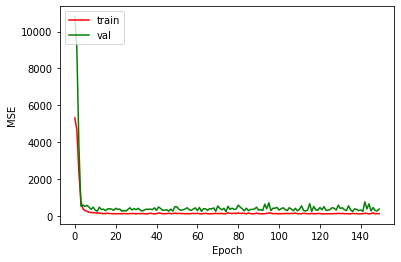

In [16]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_hz.png", dpi=200)


In [17]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 89.80142211914062 433.94439697265625 1000 epochs
# 142.0643768310547 398.6059875488281 500 epochs
# 131.62310791015625 292.6696472167969 100 epochs
# 127.3431625366211 357.522857666015

121.82166290283203 242.90023803710938
132.28041076660156 387.3313293457031


In [18]:
pred = neural_model.predict(z_test)
pred

array([[ 88.50232 ,  17.101402],
       [100.50664 ,  19.285913],
       [113.86415 ,  21.77693 ],
       [115.82776 ,  22.149698],
       [141.03767 ,  26.94766 ],
       [147.90524 ,  28.257954],
       [168.14    ,  32.143105]], dtype=float32)

In [19]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [20]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


(0.0, 2.0)

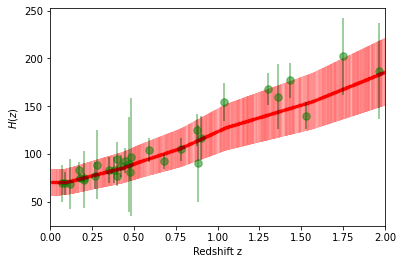

In [21]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
# plt.savefig("500_epochs_HD.png")

In [22]:
# Cosmological constants
Om = 0.27
# variance network


In [23]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

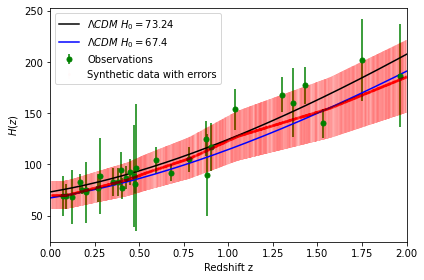

In [24]:
z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()

# plt.savefig("SyntheticHDrelu4.png",dpi=800)

In [25]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [26]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,100)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [27]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


# np.savetxt("autoEncoderHz100.dat",mookHz, delimiter=" ")

In [28]:
predy_reduced[:,1]

array([28.258665, 14.354859, 22.407137, 20.983374, 18.82889 , 32.632713,
       19.526505, 15.523774, 27.830717, 16.012411, 33.481346, 20.134014,
       19.428   , 28.593378, 27.303637, 14.027629, 33.38469 , 19.19055 ,
       21.531023, 32.855568, 23.016521, 33.37454 , 33.27609 , 29.35695 ,
       35.244118, 22.811852, 35.145424, 17.089983, 33.882896, 29.87451 ,
       34.39585 , 30.04431 , 28.71895 , 26.244146, 31.679712, 14.700662,
       27.238157, 24.144129, 14.778009, 26.244146, 20.148432, 29.363258,
       19.160534, 33.875553, 24.20206 , 28.71895 , 29.099361, 23.292885,
       28.575039, 24.251434, 15.059371, 24.901499, 34.2374  , 31.901274,
       31.322828, 29.35695 , 15.778607, 20.77691 , 26.549957, 19.712418,
       32.004208, 29.040699, 18.26531 , 31.147566, 21.18048 , 21.65171 ,
       25.205854, 25.433073, 31.289968, 26.68242 , 14.997465, 26.43308 ,
       20.637531, 29.022264, 31.791256, 26.422075, 30.802048, 24.965046,
       14.076404, 20.203989, 25.715908, 32.45362 , 

In [29]:
error  = predy_reduced[:,1]**2
error

array([ 798.5521 ,  206.06198,  502.07977,  440.30197,  354.5271 ,
       1064.8939 ,  381.2844 ,  240.98756,  774.5488 ,  256.3973 ,
       1121.0005 ,  405.37854,  377.44717,  817.5813 ,  745.4886 ,
        196.77437, 1114.5375 ,  368.2772 ,  463.58496, 1079.4884 ,
        529.76025, 1113.8599 , 1107.2981 ,  861.83057, 1242.1478 ,
        520.38055, 1235.2008 ,  292.0675 , 1148.0507 ,  892.4863 ,
       1183.0746 ,  902.6605 ,  824.7781 ,  688.7552 , 1003.6042 ,
        216.10945,  741.91724,  582.93896,  218.38956,  688.7552 ,
        405.9593 ,  862.2009 ,  367.12607, 1147.5531 ,  585.73975,
        824.7781 ,  846.7728 ,  542.5585 ,  816.53284,  588.1321 ,
        226.78465,  620.08466, 1172.1996 , 1017.6913 ,  981.11957,
        861.83057,  248.96445,  431.68002,  704.9002 ,  388.5794 ,
       1024.2693 ,  843.3622 ,  333.62155,  970.17084,  448.6127 ,
        468.79657,  635.3351 ,  646.8412 ,  979.06213,  711.9516 ,
        224.92397,  698.70776,  425.90768,  842.2918 , 1010.68

In [30]:
diagcov = np.diag(error) #inverso
# np.savetxt("autoEncoderHz_cov100.dat", diagcov, delimiter= " ", header="#100 100")
np.shape(diagcov)

(100, 100)

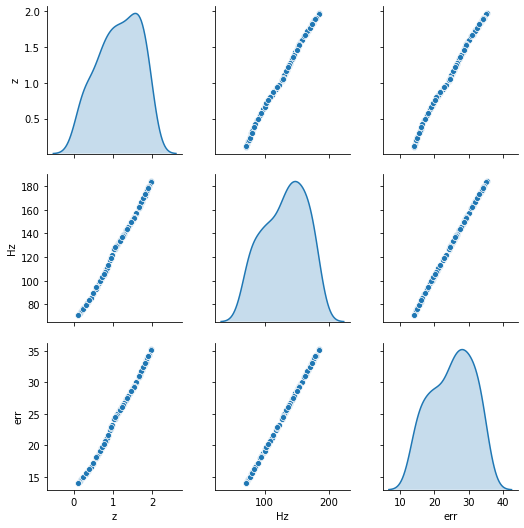

In [31]:
dfMook = pd.DataFrame(mookHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("100hdmook.png")

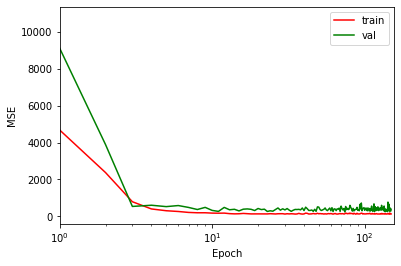

In [32]:
plt.plot(model_train.history['loss'], color='r')
plt.plot(model_train.history['val_loss'], color='g')
plt.xlim(1)
plt.xscale('log')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig("loss_hz.png", dpi=200)
# plt.savefig("epochs_for_Hz.png", dpi=200)